## Rossmann sales analysis and predictions

In [646]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas import datetime
from pandas import Series
from matplotlib import pyplot

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


In [647]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels
#from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import xgboost as xgb
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Import and check data

In [648]:
path='C:/Users/a.czepierga/Desktop/Machine Learning AI/rossmann/all (1)'
#path='C:/Users/Aleksandra/PycharmProjects/rossmann'

In [649]:
# importing train data
train = pd.read_csv(path+"/train.csv", 
                    parse_dates = True, low_memory = False)

test = pd.read_csv(path+"/test.csv", 
                    parse_dates = True, low_memory = False)

# additional store data
store = pd.read_csv(path+"/store.csv", 
                    low_memory = False)
# time series as indexes
train.index

RangeIndex(start=0, stop=1017209, step=1)

In [650]:
test.Index=test['Date']
train.Index=train['Date']

In [651]:
print("Total: ", train.shape)
train.head(5)

Total:  (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [652]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [653]:
print("Total: ", test.shape)
test.head(5)

Total:  (41088, 8)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


### Prepare data

In [658]:
# Drop duplicates 
train = train.drop_duplicates()
store = store.drop_duplicates()
# drop sales == 0 observations
train = train[train.Sales != 0]

In [669]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [670]:
train['Date'] = pd.to_datetime(train['Date'] )
test['Date'] = pd.to_datetime(test['Date'] )

In [671]:
# date extraction
train['Year']  = train['Date'].dt.year
train['Month']  = train['Date'].dt.month
train['Day']  = train['Date'].dt.day
train['WeekOfYear']  = train['Date'].dt.weekofyear

In [672]:
test['Year']  = test['Date'].dt.year
test['Month']  = test['Date'].dt.month
test['Day']  = test['Date'].dt.day
test['WeekOfYear']  = test['Date'].dt.weekofyear

In [673]:
# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844338.000000
mean          9.493641
std           2.197448
min           2.749075
25%           7.895571
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [674]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [675]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,17,38
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9,17,38
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9,17,38
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9,17,38
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9,17,38


### EDA

In [678]:
#Check continuous variables

In [679]:
#Average sales per month

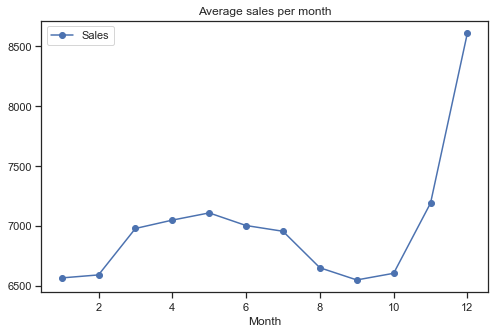

In [680]:
average_sales_per_month = train.groupby('Month')["Sales"].mean()
plt.figure(figsize=(8, 5))
average_sales_per_month.plot(legend=True, marker='o', title="Average sales per month")

In [681]:
#Sales in December! Christmas?

In [682]:
#Average sales per day

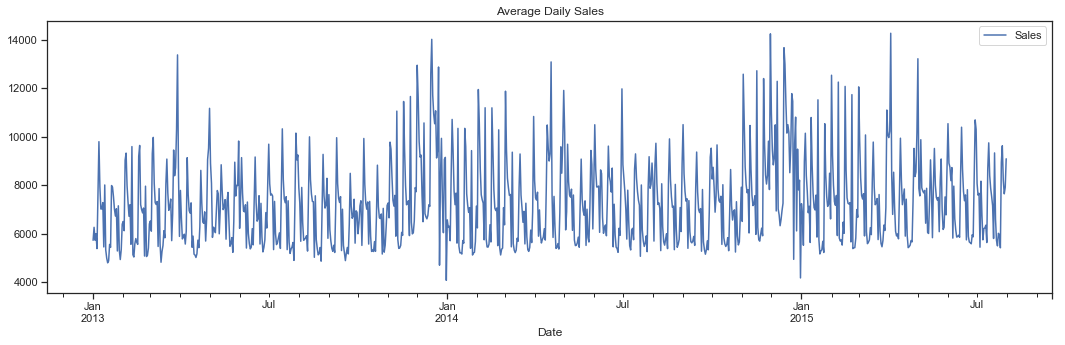

In [683]:
average_sales_per_day = train.groupby('Date')["Sales"].mean()
fig = plt.subplots(1,1, sharex=True, figsize=(18, 5))
average_sales_per_day.plot(legend=True, title="Average Daily Sales")

In [684]:
#resample by week
train['Date']=pd.to_datetime(train['Date'],format='%Y/%m/%d')
train = train.set_index(pd.DatetimeIndex(train['Date']))
train_w=train.resample('w').sum()
train_w.head()






,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,
2013-01-06,2494489,20118,26129335,3110602,4471,0,3309,9000123,4471,15647,4471,39406.143319
2013-01-13,3713468,23332,49275222,5226350,6649,5526,555,13384437,6649,63226,13298,65076.326540
2013-01-20,3716046,23359,34377765,4205743,6653,0,0,13392489,6653,109848,19959,57208.229656
2013-01-27,3722901,23398,46040169,4928833,6664,5536,0,13414632,6664,156678,26656,65073.831993
2013-02-03,3720170,23402,38466029,4507650,6665,0,128,13416645,8902,134010,33325,59686.174407


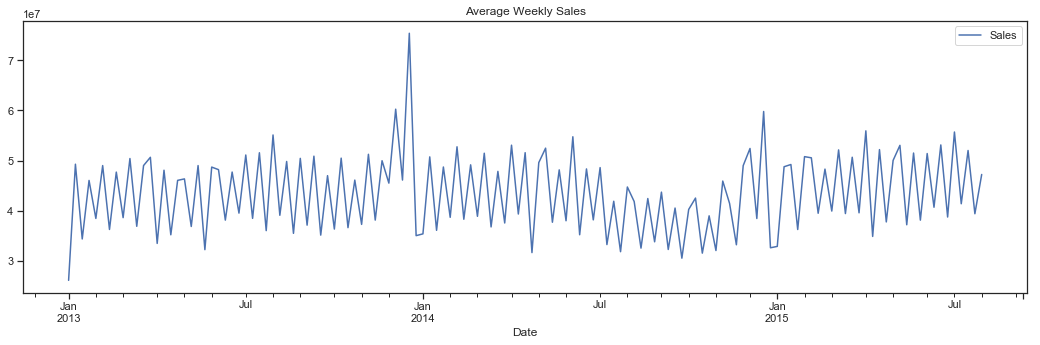

In [685]:
average_sales_per_week = train_w.groupby('Date')["Sales"].mean()
fig = plt.subplots(1,1, sharex=True, figsize=(18, 5))
average_sales_per_week.plot(legend=True, title="Average Weekly Sales")

In [686]:
#resample by month
train_m=train.resample('m').sum()
train_m.head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,
2013-01-31,16118876,101277,180132207,20380423,28865,11062,3886,58105245,28865,476025,86524,265631.275368
2013-02-28,14886979,93735,171534275,19244468,26682,11099,2656,53710866,53364,391635,191214,247653.473121
2013-03-31,15561002,100857,201180369,21969462,27891,15558,4576,56144583,83673,426814,313522,265551.020539
2013-04-30,15557765,96266,183431432,20882360,27878,13307,4294,56118414,111512,439154,439276,255665.350200
2013-05-31,14617034,96167,185411063,20723886,26199,12677,3418,52738587,130995,431541,526978,245054.639189


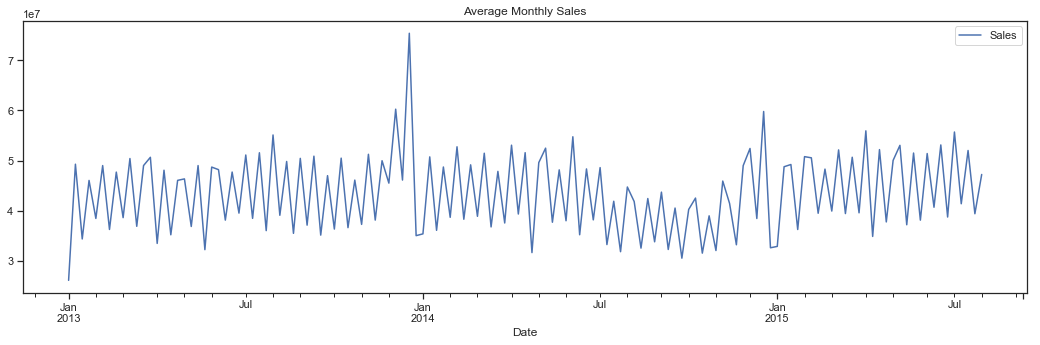

In [687]:
average_sales_per_month = train_w.groupby('Date')["Sales"].mean()
fig = plt.subplots(1,1, sharex=True, figsize=(18, 5))
average_sales_per_month.plot(legend=True, title="Average Monthly Sales")

In [688]:
#ECDF

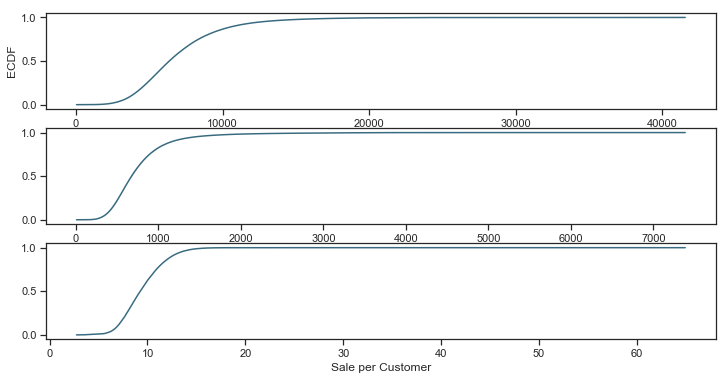

In [689]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

In [690]:
#Add interpretation

In [691]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,,


In [693]:
closed_train_store_data = test["Store"][test["Open"] == 0].values

In [694]:
closed_store_data = test["Id"][test["Open"] == 0].values

In [695]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("Total: ", zero_sales.shape)
zero_sales.head(5)

Total:  (0, 14)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,,


In [696]:
print("Closed stores and days which didn't have any sales removed from the forecast.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("Total: ", train.shape)

Closed stores and days which didn't have any sales removed from the forecast.
Total:  (844338, 14)


In [697]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [698]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [699]:
#Store details

In [700]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [701]:
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store              0
DayOfWeek          0
Date               0
Sales              0
Customers          0
Open               0
Promo              0
StateHoliday       0
SchoolHoliday      0
Year               0
Month              0
Day                0
WeekOfYear         0
SalePerCustomer    0
dtype: int64

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
Year              0
Month             0
Day               0
WeekOfYear        0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [709]:
# Stores which we don't know if they are open or not

In [710]:
test=test[pd.isnull(test.Open)==0]

In [711]:
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear


In [713]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [714]:

# replace NA's by 0# replac 
store.fillna(0, inplace = True)

In [715]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [716]:
print("Joining train dataset with store details")

train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("Total: ", train_store.shape)
train_store.head()

Joining train dataset with store details
Total:  (844338, 23)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [717]:
print("Joining test dataset with store details")

test_store = pd.merge(test, store, how = 'inner', on = 'Store')

print("Total: ", test_store.shape)
test_store.head()

Joining test dataset with store details
Total:  (41077, 21)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9,...,38,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,857,1,3,2015-09-16,1.0,1,0,0,2015,9,...,38,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1713,1,2,2015-09-15,1.0,1,0,0,2015,9,...,38,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,2569,1,1,2015-09-14,1.0,1,0,0,2015,9,...,38,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,3425,1,7,2015-09-13,0.0,0,0,0,2015,9,...,37,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [718]:
#Store types

In [719]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


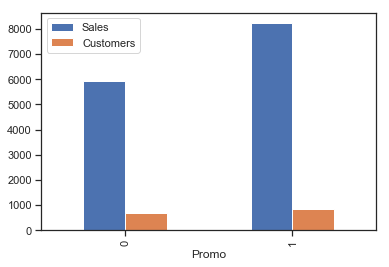

In [720]:
avg_promotion = train_store[['Sales', 'Customers', 'Promo']].groupby('Promo').mean()
avg_promotion.plot(kind='bar')

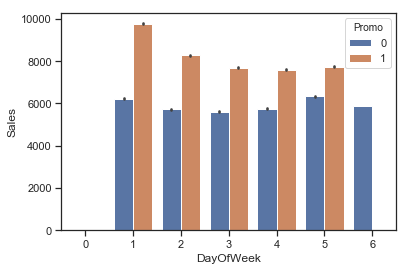

In [721]:
avg_hist_by_month = train_store[['Sales', 'Customers', 'Promo']].groupby(['Promo']).mean()
sns.barplot(x="DayOfWeek", y="Sales", hue="Promo", order=[0, 1, 2, 3, 4, 5, 6], data=train)

In [722]:
#Sales by store type

In [723]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


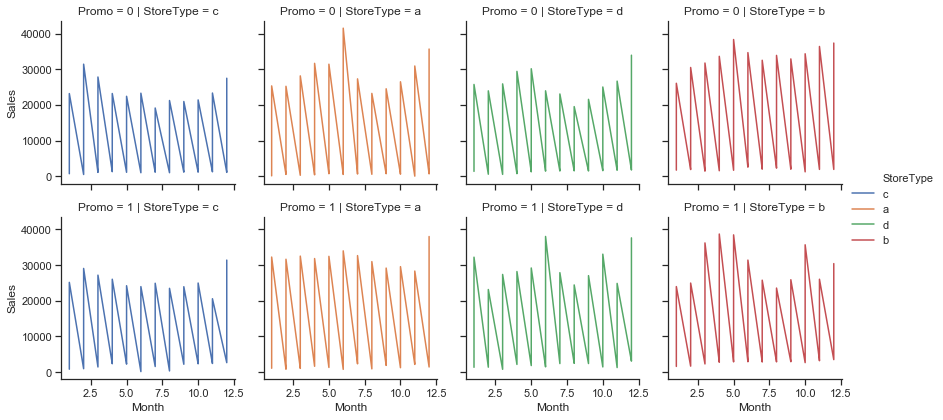

In [726]:
sns.relplot(x="Month", y="Sales", hue="StoreType",
            col="StoreType", row="Promo", height=3,
            kind="line", estimator=None, data=train_store);

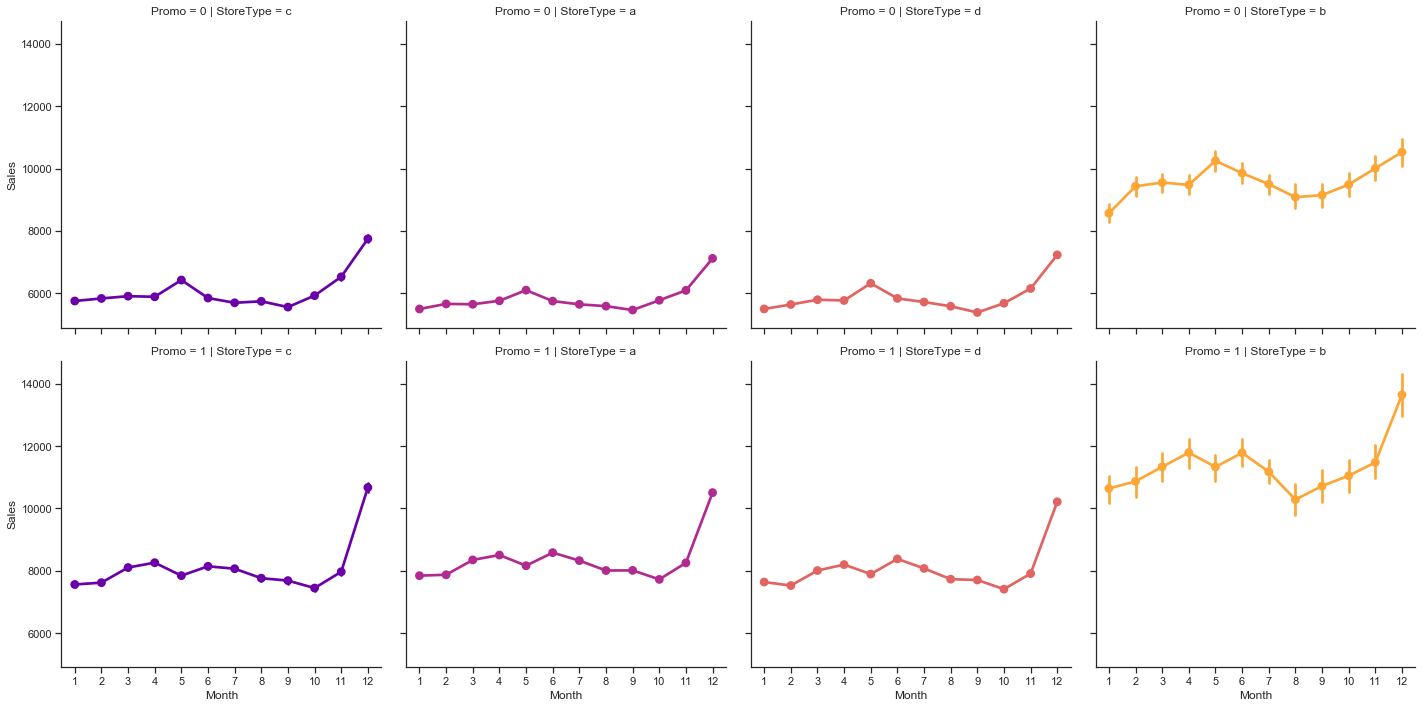

In [727]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)

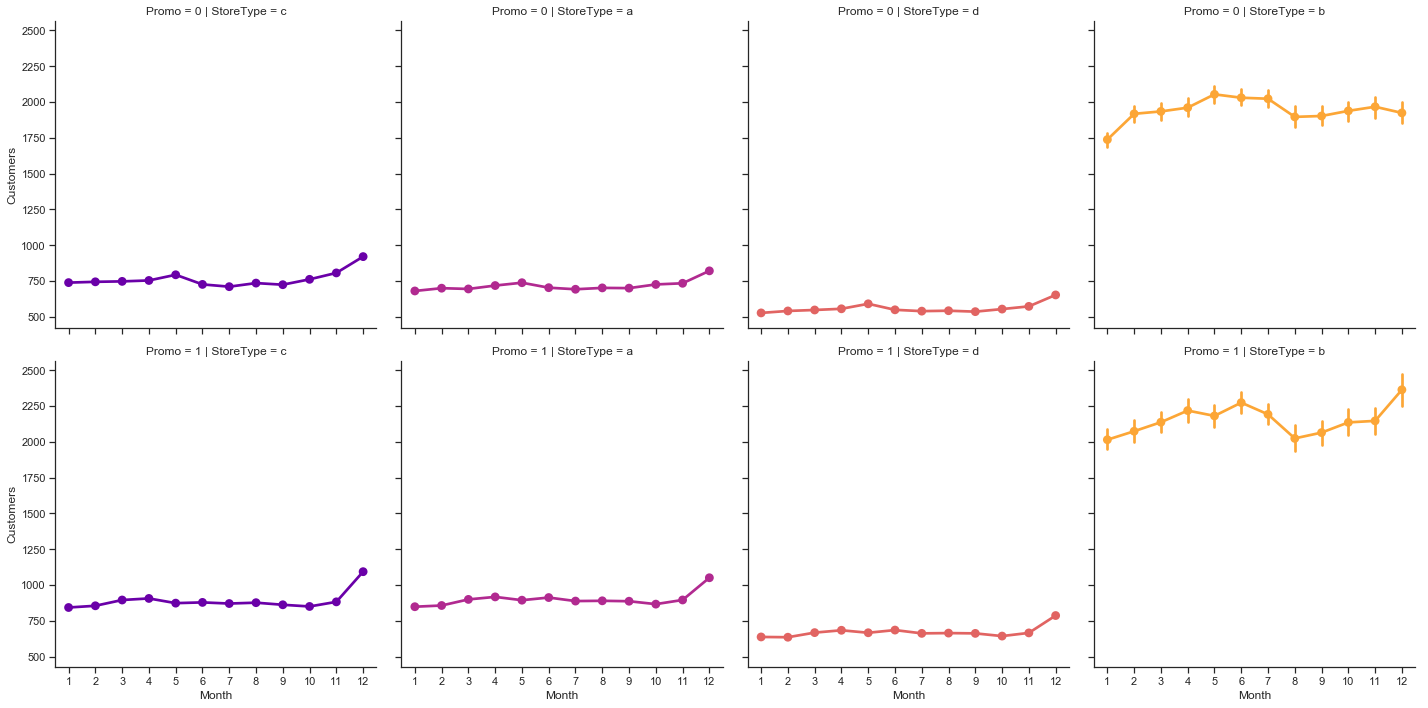

In [728]:
# customers trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)

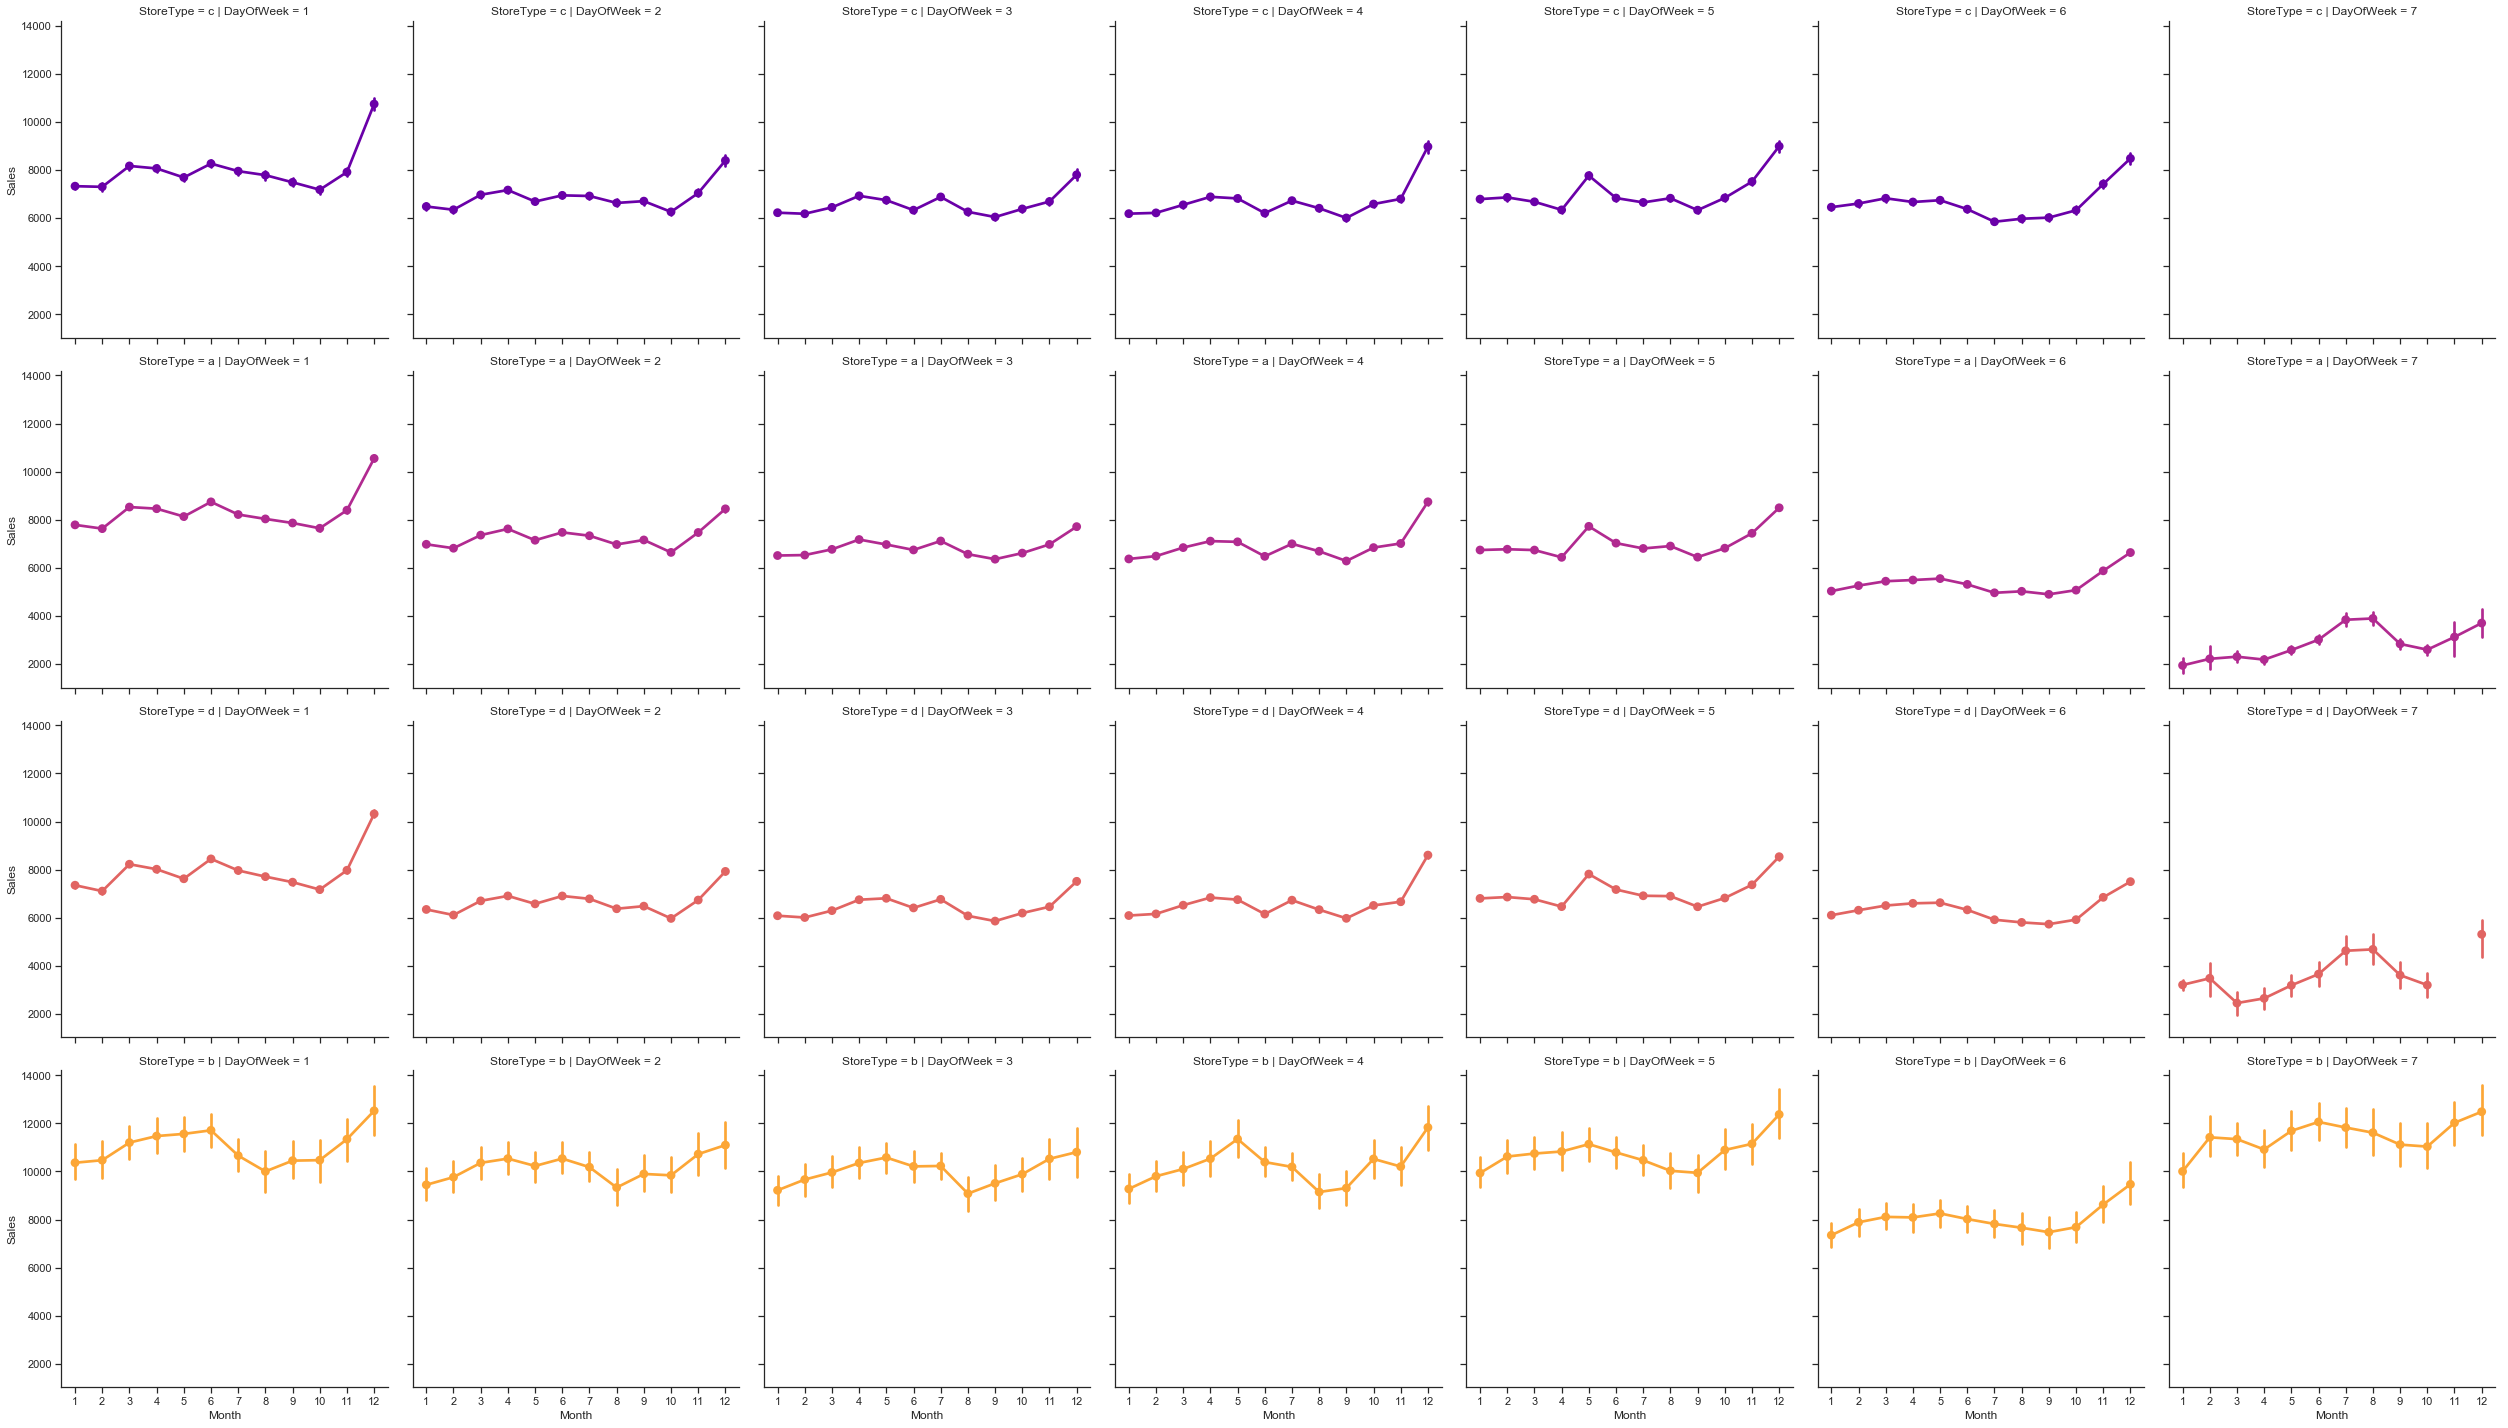

In [729]:

# sales and day of week
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c)

In [733]:
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


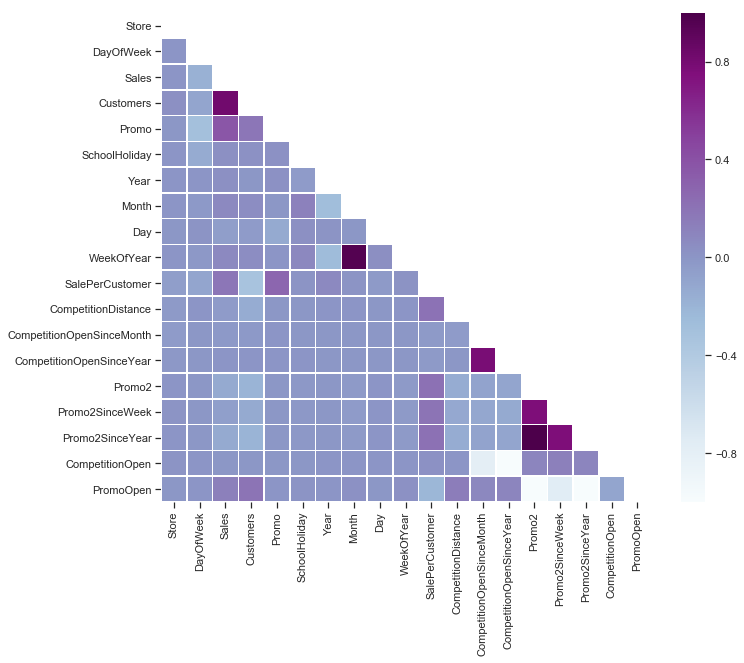

In [734]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()


In [735]:
columns_corr = ['Sales', 'Customers', 'Promo', 'Promo2','StateHoliday', 'SchoolHoliday','WeekOfYear','Month','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear']
train_store[columns_corr].corr(method='pearson')

,Sales,Customers,Promo,Promo2,SchoolHoliday,WeekOfYear,Month,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear
Sales,1.000000,0.823552,0.368199,-0.127556,0.038635,0.074463,0.073589,0.005257,-0.058493,-0.127581
Customers,0.823552,1.000000,0.182859,-0.202207,0.024915,0.053763,0.053843,0.001657,-0.130864,-0.202180
Promo,0.368199,0.182859,1.000000,-0.000316,0.028971,0.006947,-0.006412,0.000987,-0.000795,-0.000317
Promo2,-0.127556,-0.202207,-0.000316,1.000000,-0.008244,-0.024740,-0.025807,-0.098569,0.759536,0.999999
SchoolHoliday,0.038635,0.024915,0.028971,-0.008244,1.000000,0.079584,0.118467,0.000118,-0.008069,-0.008247
WeekOfYear,0.074463,0.053763,0.006947,-0.024740,0.079584,1.000000,0.960999,-0.000753,-0.030416,-0.024745
Month,0.073589,0.053843,-0.006412,-0.025807,0.118467,0.960999,1.000000,-0.000770,-0.031721,-0.025812
CompetitionOpenSinceYear,0.005257,0.001657,0.000987,-0.098569,0.000118,-0.000753,-0.000770,1.000000,-0.125078,-0.098501
Promo2SinceWeek,-0.058493,-0.130864,-0.000795,0.759536,-0.008069,-0.030416,-0.031721,-0.125078,1.000000,0.759350
Promo2SinceYear,-0.127581,-0.202180,-0.000317,0.999999,-0.008247,-0.024745,-0.025812,-0.098501,0.759350,1.000000


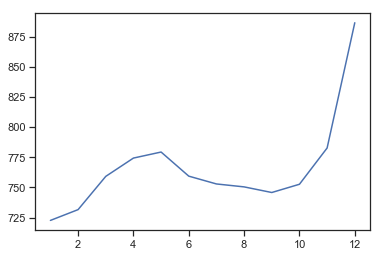

In [736]:
average_customers_per_month = train_store.groupby('Month')['Customers'].mean()
average_sales_per_month = train_store.groupby('Month')['Sales'].mean()
plt.figure(figsize=(6, 4))
plt.plot(average_customers_per_month)

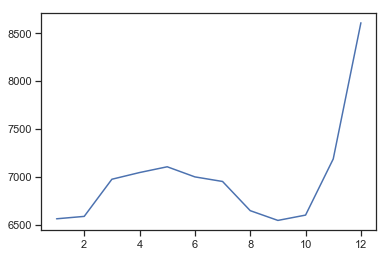

In [737]:
plt.plot(average_sales_per_month)

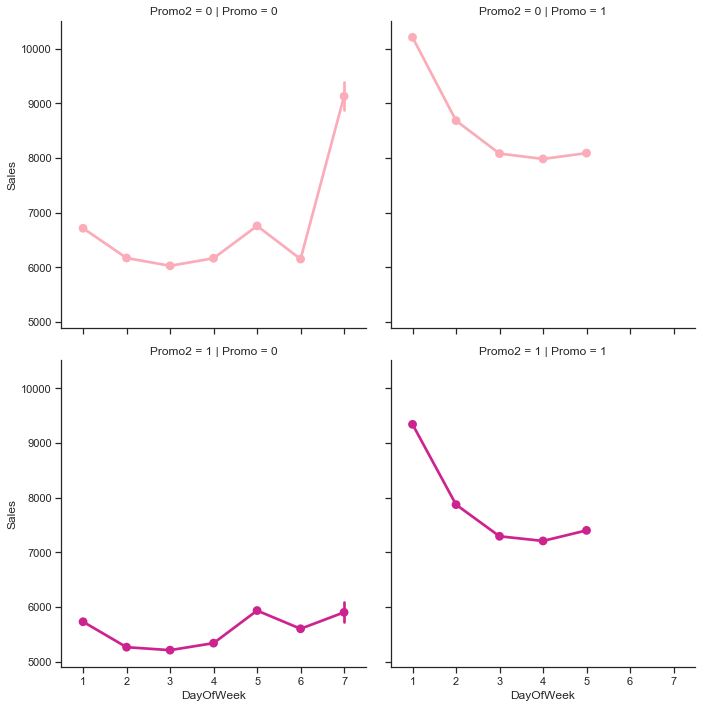

In [738]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu')

In [739]:
#Seasonality

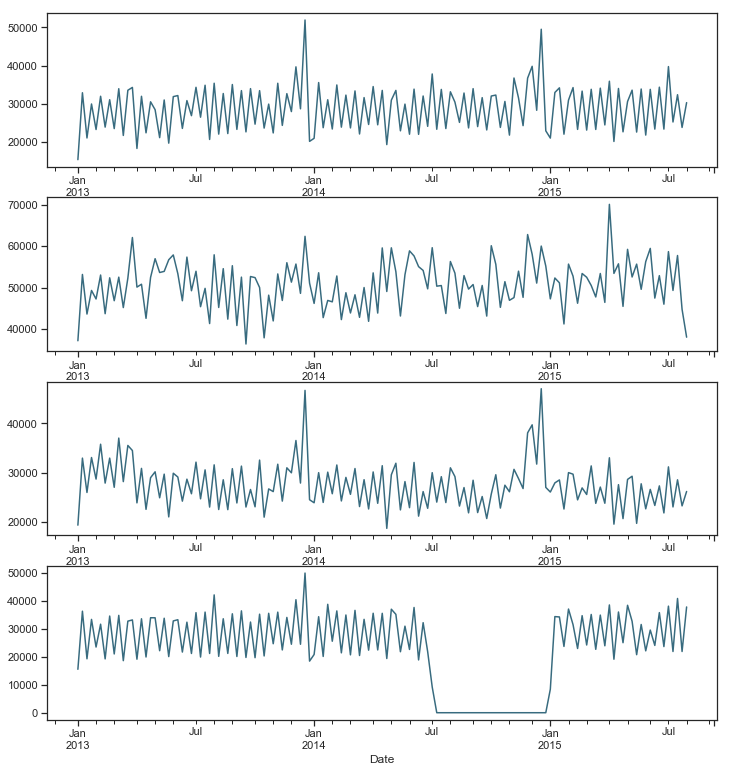

In [740]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a=sales_a.resample('W').sum()
sales_a.plot(color = c, ax = ax1)
sales_b=sales_b.resample('W').sum()
sales_b.plot(color = c, ax = ax2)
sales_c=sales_c.resample('W').sum()
sales_c.plot(color = c, ax = ax3)
sales_d=sales_d.resample('W').sum()
sales_d.plot(color = c, ax = ax4)

In [741]:
#Yearly trend

In [743]:
# Worked ok earlier?!

ValueError: operands could not be broadcast together with shapes (135,) (595,) 

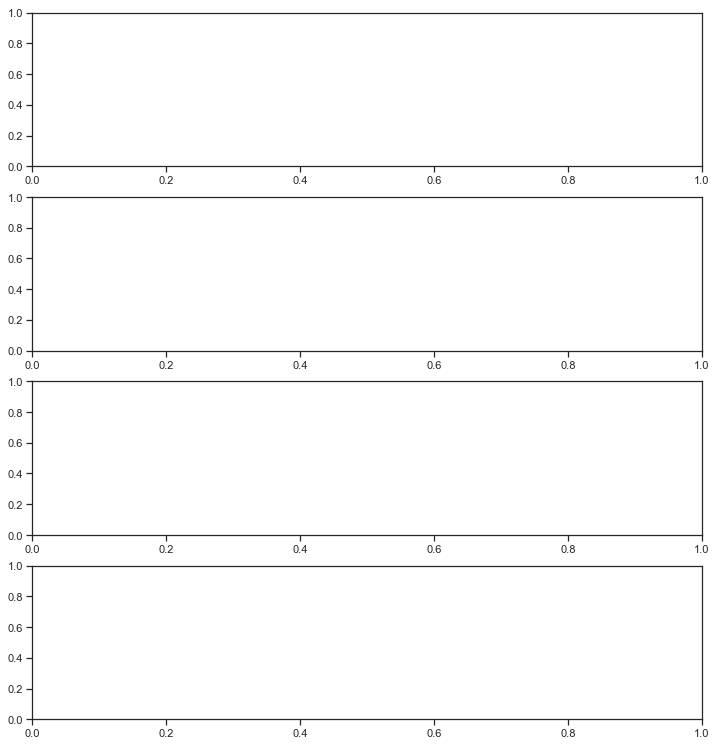

In [744]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

In [745]:

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

ValueError: operands could not be broadcast together with shapes (135,) (595,) 

Date
2013-01-06             NaN
2013-01-13             NaN
2013-01-20    23134.000000
2013-01-27    27989.333333
2013-02-03    24783.666667
2013-02-10    28422.000000
2013-02-17    26405.666667
2013-02-24    29003.333333
2013-03-03    26183.333333
2013-03-10    29531.666667
Freq: W-SUN, Name: Sales, dtype: float64


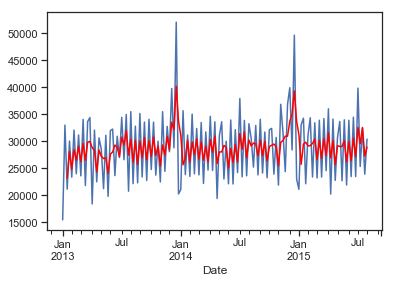

In [746]:
# Tail-rolling average transform
rolling = sales_a.rolling(window=3)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
# plot original and transformed dataset
sales_a.plot()
rolling_mean.plot(color='red')
pyplot.show()

In [747]:
#Autocorrelation

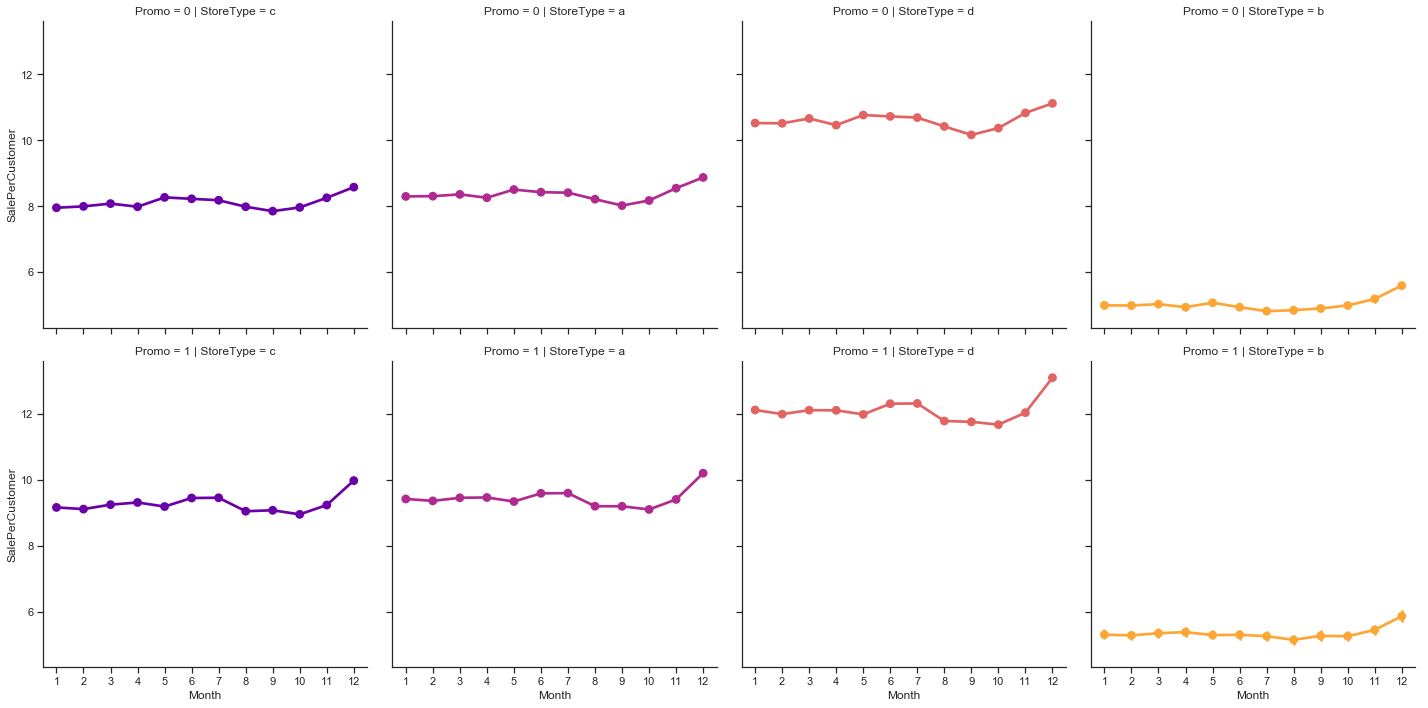

In [748]:
# sales per customer trends
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c)

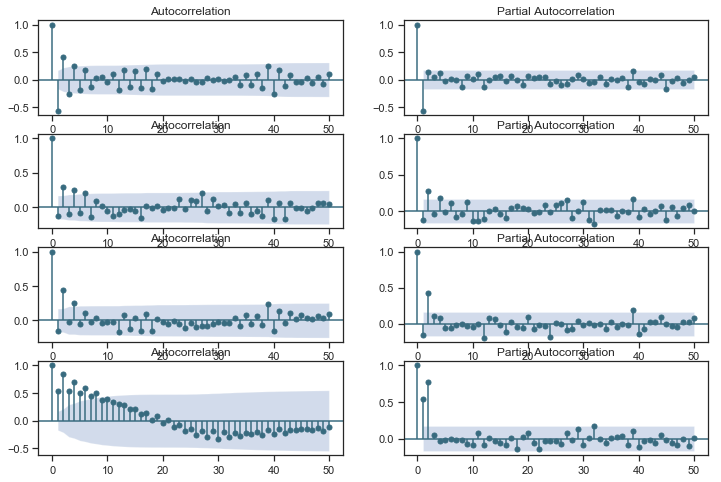

In [749]:
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

## Forecast

In [776]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import Holt
#from statsmodels.tsa.api import SimpleExpSmoothing,ExponentialSmoothing


In [ ]:
## Moving average

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = sales_a.rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(sales_a, label='Train')
#plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [751]:

y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(sales_a)).fit(smoothing_level=0.6,optimized=False)

y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(sales_a, label='Train')
#plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()


AttributeError: 'SimpleExpSmoothing' object has no attribute '_index'

In [752]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(sales_a).plot()
result = sm.tsa.stattools.adfuller(sales_a)
plt.show()

ImportError: cannot import name 'PytestTester'

In [753]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(sales_a)).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(sales_a, label='Train')
#plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

AttributeError: 'Holt' object has no attribute '_index'

In [754]:
#???

In [755]:
features=['Sales','Customers','Store','DayOfWeek','Open','Promo','SchoolHoliday','HolidayBin','Year','Month','Day','WeekOfYear']

In [756]:
train["HolidayBin"] = train.StateHoliday.map({"0": 0, "a": 1, "b": 1, "c": 1})
del train['StateHoliday']

In [757]:
closed_store_data = test["Id"][test["Open"] == 0].values

In [758]:
test["HolidayBin"] = test.StateHoliday.map({"0": 0, "a": 1, "b": 1, "c": 1})
del test['StateHoliday']


In [759]:
test.shape

(41077, 12)

In [760]:
train.shape

(844338, 14)

In [761]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,HolidayBin
0,1,1,4,2015-09-17,1.0,1,0,2015,9,17,38,0
1,2,3,4,2015-09-17,1.0,1,0,2015,9,17,38,0
2,3,7,4,2015-09-17,1.0,1,0,2015,9,17,38,0
3,4,8,4,2015-09-17,1.0,1,0,2015,9,17,38,0
4,5,9,4,2015-09-17,1.0,1,0,2015,9,17,38,0


In [762]:
train_stores = dict(list(train[features].groupby('Store')))
test_stores = dict(list(test.groupby('Store')))

In [763]:
result = pd.Series()
result2 = pd.Series()
for i in test_stores:  
    store = train_stores[i]
    X_train = store.drop(["Sales", "Store", "Customers"],axis=1)
    Y_train = store["Sales"]
    X_test  = test_stores[i].copy()   
    store_ind = X_test["Id"]
    X_test.drop(["Id","Store"], axis=1,inplace=True)
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())
   
    estimator = RandomForestRegressor(n_estimators=9, max_depth=10, criterion = 'mse')
    estimator.fit(X_train, Y_train)
    Y_pred = estimator.predict(X_test)
    result = result.append(pd.Series(Y_pred, index=store_ind))
    
    estimator2 = LinearRegression()
    estimator2.fit(X_train, Y_train)
    Y_pred2 = estimator2.predict(X_test)
    result2 = result2.append(pd.Series(Y_pred, index=store_ind))
    
    
#result = result.append(pd.Series(0, index=closed_store_data))
result = pd.DataFrame({ "Id": result.index, "Sales": result.values})
result.to_csv('result_new.csv', index=False)
#result2 = result2.append(pd.Series(0, index=closed_store_data))
result2 = pd.DataFrame({ "Id": result2.index, "Sales": result2.values})
result2.to_csv('result_2.csv', index=False)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [764]:
#xgboost

In [765]:
#Generate hold out set

In [766]:
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,PromoOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75


In [767]:
train_store = pd.merge(train, store, on='Store')
test_store = pd.merge(test, store, on='Store')

In [768]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer,HolidayBin
Date,,,,,,,,,,,,,,
2015-07-31,1,5,2015-07-31,5263.0,555,1,1,1,2015,7,31,31,9.482883,0
2015-07-31,2,5,2015-07-31,6064.0,625,1,1,1,2015,7,31,31,9.702400,0
2015-07-31,3,5,2015-07-31,8314.0,821,1,1,1,2015,7,31,31,10.126675,0
2015-07-31,4,5,2015-07-31,13995.0,1498,1,1,1,2015,7,31,31,9.342457,0
2015-07-31,5,5,2015-07-31,4822.0,559,1,1,1,2015,7,31,31,8.626118,0


In [769]:
train_store = train_store.sort_values(['Date'],ascending = False)
ho_test = test_store[:6*7*1115]
ho_train = train_store[6*7*1115:]

In [770]:
features=['DayOfWeek','Date','Open','Promo','SchoolHoliday','HolidayBin','Year','Month','Day','WeekOfYear']

In [771]:
y_train = np.log1p(Y_train)
y_test = np.empty(48)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_test[features], y_test)


ho_xtrain = ho_train.drop(['Sales'],axis=1 ) 
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['Sales'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)

KeyError: "['Date'] not in index"

In [480]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [481]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 3000

In [482]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round,evals=watchlist,early_stopping_rounds=50,verbose_eval=True)

[0]	train-rmse:5.75784	eval-rmse:1.86894e+06
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:4.03789	eval-rmse:1.86894e+06
[2]	train-rmse:2.83372	eval-rmse:1.86894e+06
[3]	train-rmse:1.99344	eval-rmse:1.86894e+06
[4]	train-rmse:1.40756	eval-rmse:1.86894e+06
[5]	train-rmse:1.00061	eval-rmse:1.86894e+06
[6]	train-rmse:0.718737	eval-rmse:1.86894e+06
[7]	train-rmse:0.517669	eval-rmse:1.86894e+06
[8]	train-rmse:0.377392	eval-rmse:1.86894e+06
[9]	train-rmse:0.281606	eval-rmse:1.86894e+06
[10]	train-rmse:0.217431	eval-rmse:1.86894e+06
[11]	train-rmse:0.170397	eval-rmse:1.86894e+06
[12]	train-rmse:0.13685	eval-rmse:1.86894e+06
[13]	train-rmse:0.112422	eval-rmse:1.86894e+06
[14]	train-rmse:0.096623	eval-rmse:1.86894e+06
[15]	train-rmse:0.084244	eval-rmse:1.86894e+06
[16]	train-rmse:0.074864	eval-rmse:1.86894e+06
[17]	train-rmse:0.065426	eval-rmse:1.86894e+06
[18]	train-rmse:0.058701	eva

In [489]:
print("Validating")
#yhat = gbm.predict(xgb.DMatrix(X_test[features]))

print("validating")
ho_xtest.sort_index(inplace=True) 
ho_ytest.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(ho_xtest))
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

Validating
validating


NameError: name 'ho_xtest' is not defined

In [484]:
yhat

array([8.860265, 8.8147  , 8.888036, 9.214473, 8.918866, 8.867452,
       8.694681, 8.710507, 8.71007 , 8.691577, 8.778832, 8.866486,
       8.965041, 9.136914, 9.035247, 8.991012, 9.008096, 9.181234,
       9.013287, 8.923295, 8.787486, 8.661351, 8.548182, 8.511531,
       8.597846, 8.718276, 8.719346, 8.952326, 8.968903, 8.892367,
       8.960935, 9.239857, 8.756003, 8.789639, 8.677792, 8.726477,
       8.604905, 8.684689, 8.721867, 8.857172, 8.838988, 8.921839,
       8.927784, 8.90832 , 8.990806, 9.161888, 8.875544, 8.878153],
      dtype=float32)

In [485]:
error = rmspe(X_test.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

AttributeError: 'DataFrame' object has no attribute 'Sales'

In [486]:
print("Make predictions on the test set")
dtest = xgb.DMatrix(test[features])



Make predictions on the test set


KeyError: "['Date'] not in index"

In [487]:
test_probs

array([8.860265, 8.860265, 8.860265, ..., 8.910154, 8.910154, 8.878153],
      dtype=float32)

In [488]:
# Make Submission
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv("xgboost_10_submission.csv", index=False)


ValueError: array length 41088 does not match index length 41077

### XGBOOST

In [778]:
features=['DayOfWeek','Open','Promo','SchoolHoliday','HolidayBin','Year','Month','Day','WeekOfYear']

In [779]:
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

In [780]:

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)


[0]	train-rmse:5.79435	eval-rmse:5.79272	train-rmspe:0.99682	eval-rmspe:0.996822
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.06501	eval-rmse:4.0633	train-rmspe:0.981306	eval-rmspe:0.981314
[2]	train-rmse:2.85775	eval-rmse:2.85616	train-rmspe:0.937221	eval-rmspe:0.937214
[3]	train-rmse:2.01778	eval-rmse:2.01593	train-rmspe:0.854739	eval-rmspe:0.854472
[4]	train-rmse:1.43665	eval-rmse:1.43471	train-rmspe:0.741624	eval-rmspe:0.740366
[5]	train-rmse:1.03926	eval-rmse:1.03703	train-rmspe:0.619749	eval-rmspe:0.615961
[6]	train-rmse:0.772923	eval-rmse:0.770454	train-rmspe:0.51339	eval-rmspe:0.504893
[7]	train-rmse:0.600706	eval-rmse:0.597807	train-rmspe:0.439399	eval-rmspe:0.42399
[8]	train-rmse:0.494652	eval-rmse:0.491558	train-rmspe:0.401463	eval-rmspe:0.378738
[9]	train-rmse:0.433343	eval-rmse:0.430135	train-rmspe:0.391609	eval-rmspe:0.362927
[10]	train-rmse:0.399712	eval-

[96]	train-rmse:0.363672	eval-rmse:0.361001	train-rmspe:0.456546	eval-rmspe:0.419103
[97]	train-rmse:0.363673	eval-rmse:0.361009	train-rmspe:0.456557	eval-rmspe:0.418976
[98]	train-rmse:0.363673	eval-rmse:0.361008	train-rmspe:0.456583	eval-rmspe:0.419004
[99]	train-rmse:0.363673	eval-rmse:0.361021	train-rmspe:0.456592	eval-rmspe:0.419053
[100]	train-rmse:0.363673	eval-rmse:0.361032	train-rmspe:0.456638	eval-rmspe:0.419045
[101]	train-rmse:0.363673	eval-rmse:0.361034	train-rmspe:0.456561	eval-rmspe:0.419
[102]	train-rmse:0.363672	eval-rmse:0.361064	train-rmspe:0.456597	eval-rmspe:0.419292
[103]	train-rmse:0.363672	eval-rmse:0.361076	train-rmspe:0.456558	eval-rmspe:0.419317
[104]	train-rmse:0.363673	eval-rmse:0.361041	train-rmspe:0.456698	eval-rmspe:0.419352
[105]	train-rmse:0.363672	eval-rmse:0.361054	train-rmspe:0.456638	eval-rmspe:0.419296
[106]	train-rmse:0.363672	eval-rmse:0.361066	train-rmspe:0.456579	eval-rmspe:0.41926
[107]	train-rmse:0.363671	eval-rmse:0.361063	train-rmspe:0.456

In [781]:
print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))



Validating
RMSPE: 0.419394


In [782]:
print("Make predictions on the test set")
dtest = xgb.DMatrix(test[features])
test_probs = gbm.predict(dtest)
# Make Submission
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv("xgboost_10_submission.csv", index=False)

Make predictions on the test set
